In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
from sklearn.utils import class_weight
import config

In [2]:
# Load the dataset
train_ds, test_ds, _ = config.get_datasets()

# Get the class weights
all_labels = []
outputs = np.concatenate([i for x, i in train_ds], axis=0)
for y in outputs:
    all_labels.append(config.label_names[np.argmax(y)])
all_labels = np.array(all_labels)


class_weights = class_weight.compute_class_weight(class_weight='balanced',                                                  
                                                    classes=np.unique(all_labels),                                                 
                                                    y=all_labels)

# change the format of the class weights to a dictionary
class_weights = {i: class_weights[i] for i in range(config.n_classes)} 

print(f"Generated class weights for an imbalanced dataset: {class_weights}")

Found 3764 files belonging to 7 classes.


2024-12-03 12:20:56.397314: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-03 12:20:56.397345: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-03 12:20:56.397360: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-03 12:20:56.397642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 12:20:56.397659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Generated class weights for an imbalanced dataset: {0: 1.3772893772893773, 1: 1.0662885501595178, 2: 1.1489686783804431, 3: 0.840928152082751, 4: 0.8769679300291545, 5: 0.9591836734693877, 6: 0.9142857142857143}


2024-12-03 12:20:57.832289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-12-03 12:25:13.503664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


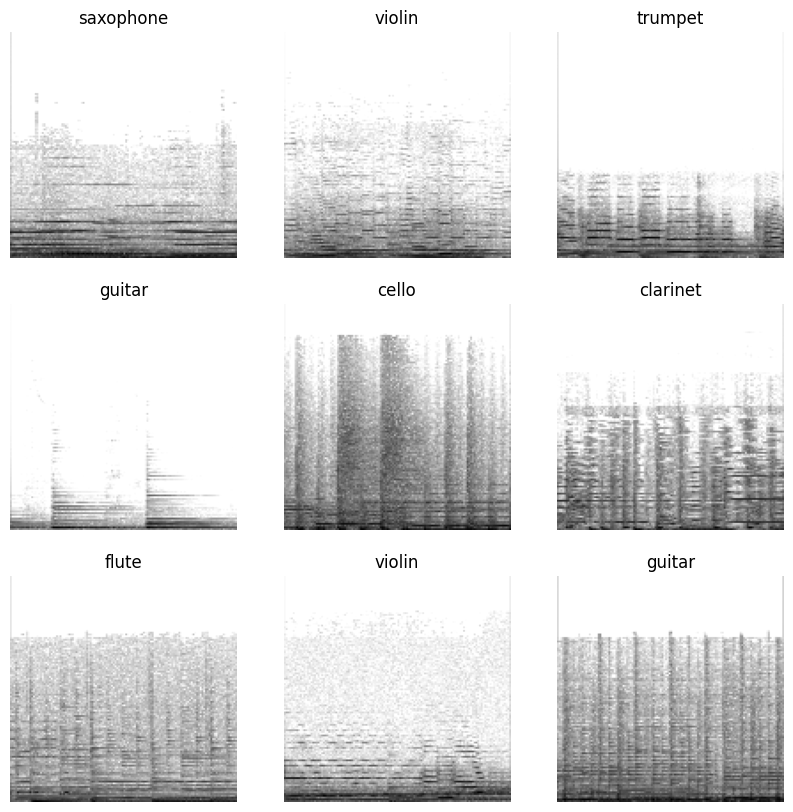

In [30]:
# print(f"Classes: {train_ds.class_names}")
classes = []
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  j = 0
  for i in range(32):
    lbl = config.label_names[np.argmax(labels[i])]
    if lbl not in classes or len(classes) >= 7 and j < 9:
      classes.append(lbl)
      plt.subplot(3, 3, j+1)
      plt.imshow(images[i], cmap='gray')
      plt.title(config.label_names[np.argmax(labels[i])])
      plt.axis("off")
      j += 1
plt.show()


In [4]:
print(f"Training data size (batches): {train_ds.cardinality()}")
print(f"Testing data size (batches): {test_ds.cardinality()}")

Training data size (batches): 94
Testing data size (batches): 11


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model = keras.Sequential()
model.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model.add(keras.layers.RandomTranslation(0.1, 0.1))
model.add(keras.layers.RandomBrightness(0.1))
model.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

# Dense Layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation              │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
for batch in train_ds.take(1).as_numpy_iterator():
    imgs, labels = batch
    out = model.predict(imgs)
    print(out.shape)
    for i in range(1):
        print(f"Output: {out[i]} | Max Idx: {np.argmax(out[i])} | Class Name: {config.label_names[np.argmax(out[i])]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
(32, 7)
Output: [0.16830377 0.13982005 0.19117835 0.13638349 0.1305265  0.10849196
 0.12529586] | Max Idx: 2 | Class Name: flute


2024-12-01 11:10:11.595005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
history = model.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - auc_1: 0.5916 - categorical_accuracy: 0.1993 - f1_score: 0.1709 - loss: 1.9102 - precision_1: 0.0158 - recall_1: 1.0536e-05 - val_auc_1: 0.6501 - val_categorical_accuracy: 0.2528 - val_f1_score: 0.1587 - val_loss: 1.8425 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - auc_1: 0.6174 - categorical_accuracy: 0.2166 - f1_score: 0.1839 - loss: 1.8823 - precision_1: 0.2888 - recall_1: 5.5405e-04 - val_auc_1: 0.6578 - val_categorical_accuracy: 0.2699 - val_f1_score: 0.2192 - val_loss: 1.8421 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc_1: 0.6120 - categorical_accuracy: 0.2214 - f1_score: 0.1961 - loss: 1.8827 - precision_1: 0.6012 - recall_1: 7.0429e-04 - val_auc_1: 0.6608 - val_categorical_accuracy: 0.2869 - val_f1_score: 0.2592 - val_loss: 1.8295 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4

### Plotting

In [18]:
# plot history of training
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

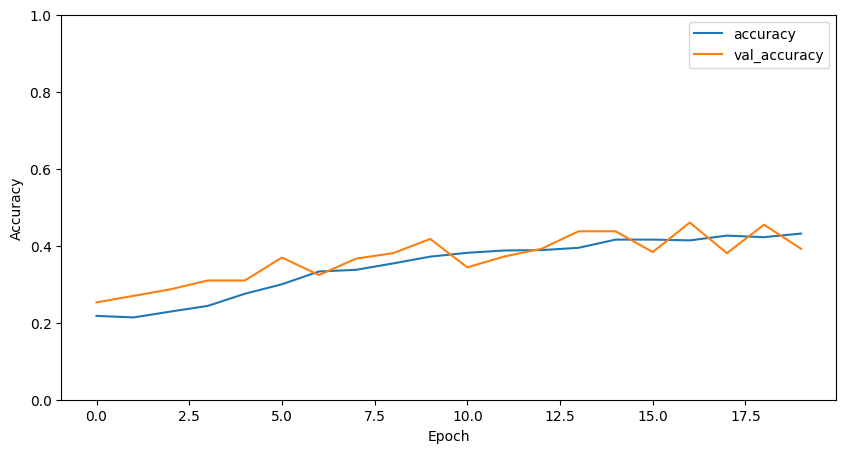

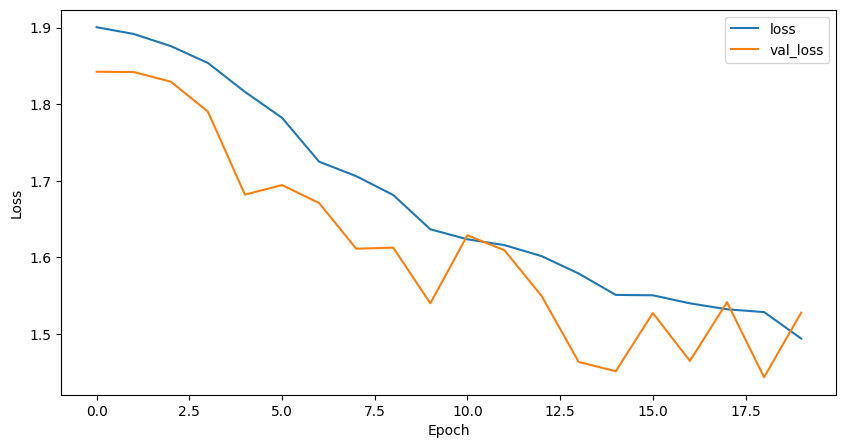

In [21]:
plot_history(history)

In [25]:
# Save the model
model.save("models/instrument-recognition-4.keras")

AttributeError: The layer sequential_2 has never been called and thus has no defined input.